# **Análise Comparativa de PIB e IDH Brasil**

[Fonte](https://datahub.io/core/gdp#data) e [Licença](https://opendatacommons.org/licenses/pddl/1-0/) do dataset (PIB).

[Fonte](https://hdr.undp.org/data-center/documentation-and-downloads) e [Licença](https://hdr.undp.org/terms-use) dos indicadores.

## Otávio Marinho

## Introdução

Este projeto explora indicadores econômicos e sociais para responder a perguntas-chave sobre o posicionamento do Brasil no cenário global. Analisamos dados de PIB, crescimento econômico e Índice de Desenvolvimento Humano (IDH), com foco especial em países em desenvolvimento, países desenvolvidos, e BRICS.


## Importando as Bibliotecas que serão utilizadas no projeto

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importação e Carregamento de Dados
Dados econômicos globais e os índices compostos de qualidade de vida para análise.

In [4]:
# Dados de PIB
gdp_data = pd.read_csv("gdp_data.csv", index_col=None)

# Dados de índices compostos
composite_indices = pd.read_csv('composite_indices.csv', index_col=None)

## Limpeza e Pré-Processamento dos Dados

Identificaram-se colunas com formatos inadequados, incluindo valores numéricos armazenados como texto com pontuação indevida. Para realizar a conversão para o formato float, foi necessário remover os pontos de separação. Além disso, foi preciso ajustar os valores da coluna IDH, onde alguns registros apresentavam três casas decimais e ultrapassavam o limite máximo de 1, exigindo correção.

In [12]:
in_development_countries = [
    'ARG', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN', 'BOL',
    'IND', 'PAK', 'BGD', 'NGA', 'ETH', 'KEN', 'MOZ', 'ZAF', 'EGY', 'MAR', 'IDN', 'PHL',
    'VNM', 'THA', 'TUR', 'UZB', 'SDN', 'YEM', 'LKA'
]
developed_countries = [
    'USA', 'CAN', 'GBR', 'FRA', 'DEU', 'ITA', 'JPN', 'AUS', 'NZL', 'KOR', 'NLD', 'DNK',
    'NOR', 'SWE', 'FIN', 'CHE', 'BEL', 'AUT', 'PRT', 'ISL', 'IRL', 'ESP', 'GRC', 'LUX',
    'HUN', 'CZE', 'POL', 'SVK', 'LTU', 'LVA', 'EST'
]

# Filtrar dados relevantes
gdp_data_cleaned = gdp_data[gdp_data['Country Code'].isin(in_development_countries + developed_countries)]
gdp_data_cleaned['is_developed'] = gdp_data_cleaned['Country Code'].isin(developed_countries)

# Extração de colunas relevantes
country_codes = composite_indices.iloc[:, 0]
hdi_data = composite_indices.loc[:, 'hdi_2022']
life_expectancy_data = composite_indices.loc[:, 'le_2022']
population_data = composite_indices.loc[:, 'pop_total_2022']
gnipc_data = composite_indices.loc[:, 'gnipc_2022']

# Criação do DataFrame consolidado
world_data = pd.concat([country_codes, hdi_data, life_expectancy_data, population_data, gnipc_data], axis=1)

# Ajuste do formato do IDH
def format_hdi(value):
    try:
        if value > 1:
            value = value / 1000
        return round(value, 3)
    except Exception as e:
        return value

world_data['hdi_2022'] = world_data['hdi_2022'].apply(format_hdi)

# Conversão de colunas
def convert_to_float(value, is_le=False):
    try:
        if is_le:
            return float(value)
        else:
            value = value.replace('.', '')
            return float(value)
    except:
        return np.nan

world_data['le_2022'] = world_data['le_2022'].apply(convert_to_float, is_le=True)
cols_to_convert = ['pop_total_2022', 'gnipc_2022']
for col in cols_to_convert:
    world_data[col] = world_data[col].apply(convert_to_float)

### 2. Cálculo de Crescimento Econômico

Achei interessante demonstrar como o PIB dos países dos BRICS mudam em média ao longo dos anos ao invés de uma soma bruta.

In [6]:
# Dados dos BRICS
brics_countries = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']
brics_data = gdp_data[gdp_data['Country Code'].isin(brics_countries)]

# Crescimento anual (variação percentual ano a ano)
brics_data['Growth'] = brics_data.groupby('Country Code')['Value'].pct_change() * 100

# Tratar valores nulos e outliers
brics_data['Growth'] = brics_data['Growth'].fillna(0)
q1 = brics_data['Growth'].quantile(0.25)
q3 = brics_data['Growth'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
brics_data['Growth'] = np.clip(brics_data['Growth'], lower_bound, upper_bound)

## Análise Exploratória

### Análise 1: Crescimento Econômico do Brasil
Comparamos o crescimento econômico do Brasil com a média dos países em desenvolvimento.

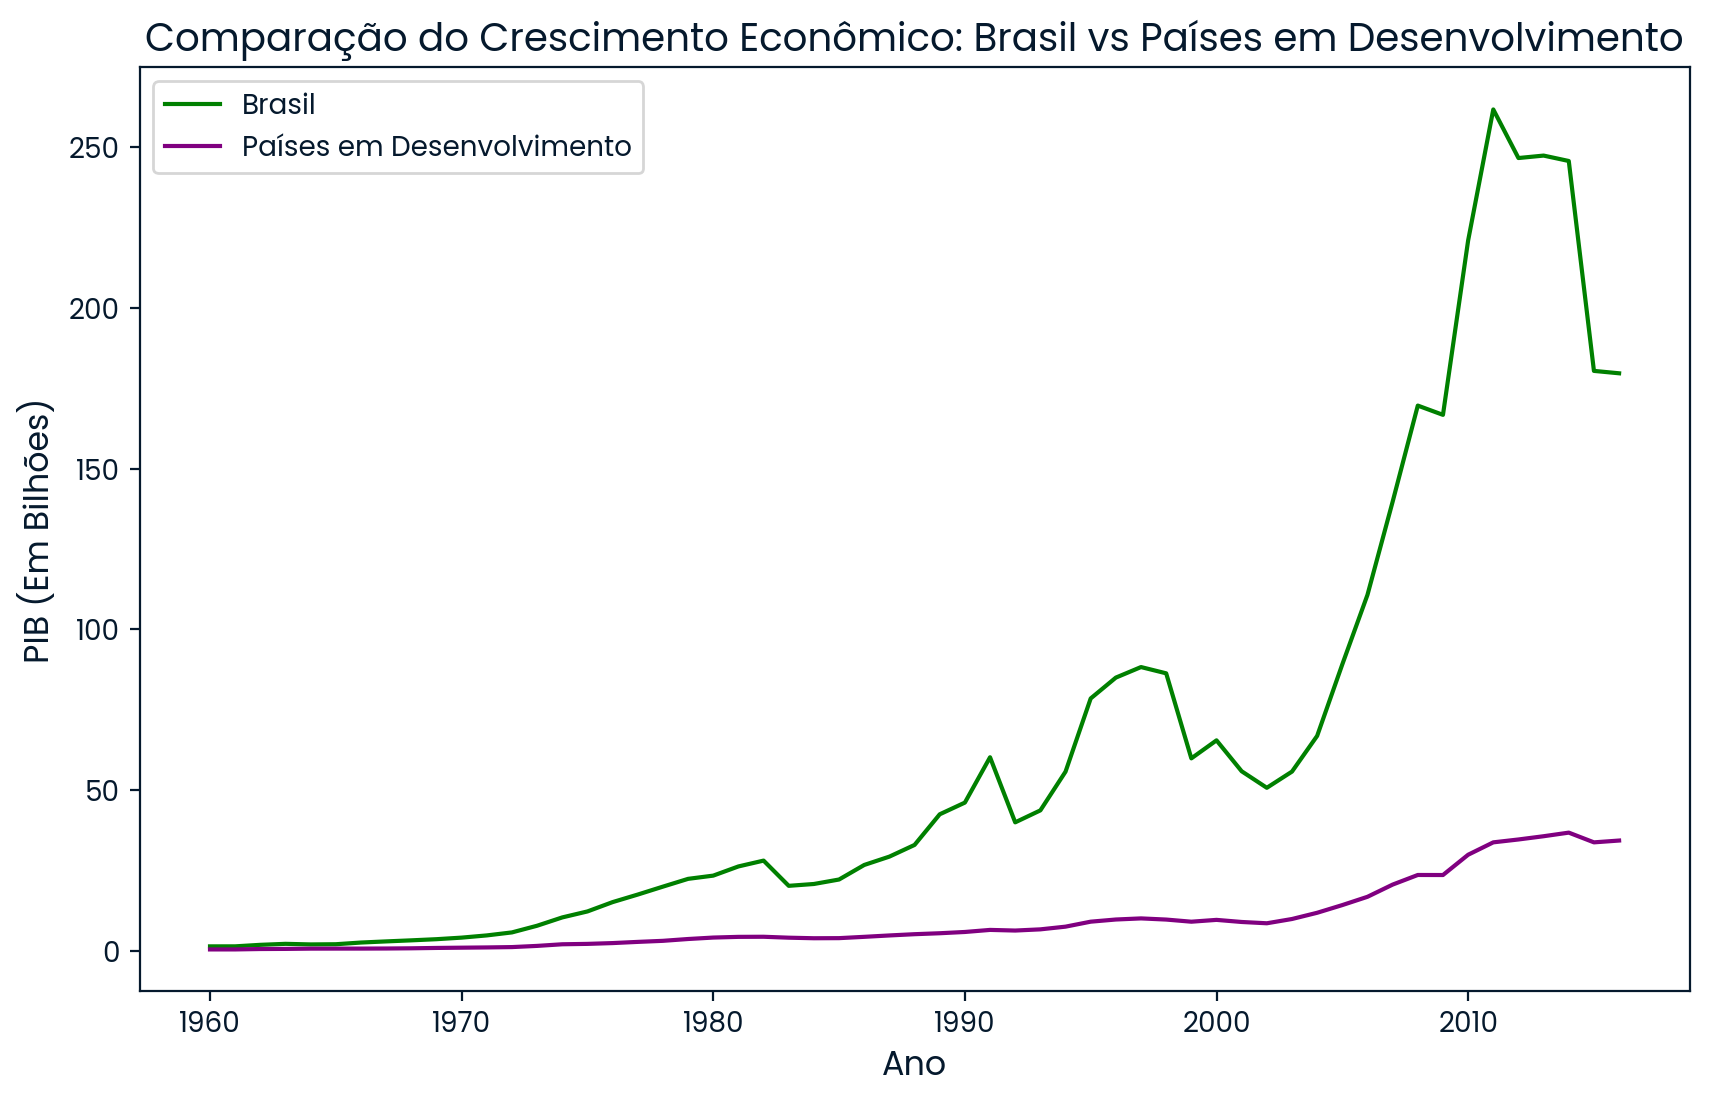

In [7]:
# Dados do Brasil
brazil_data = gdp_data_cleaned[gdp_data_cleaned['Country Code'] == 'BRA']

# Dados de países em desenvolvimento
in_development_data = gdp_data_cleaned[gdp_data_cleaned['is_developed'] == False]
gdp_in_development = in_development_data.groupby('Year')['Value'].mean().reset_index()

# Visualização
plt.figure(figsize=(10, 6))
sns.lineplot(data=brazil_data, x='Year', y=brazil_data['Value'] / 1e10, label='Brasil', color='green', ci=None)
sns.lineplot(data=gdp_in_development, x='Year', y=gdp_in_development['Value'] / 1e10, label='Países em Desenvolvimento', color='purple', ci=None)
plt.title('Comparação do Crescimento Econômico: Brasil vs Países em Desenvolvimento', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('PIB (Em Bilhões)', fontsize=12)
plt.legend()
plt.show()

### Análise 2: Crescimento Anual dos BRICS

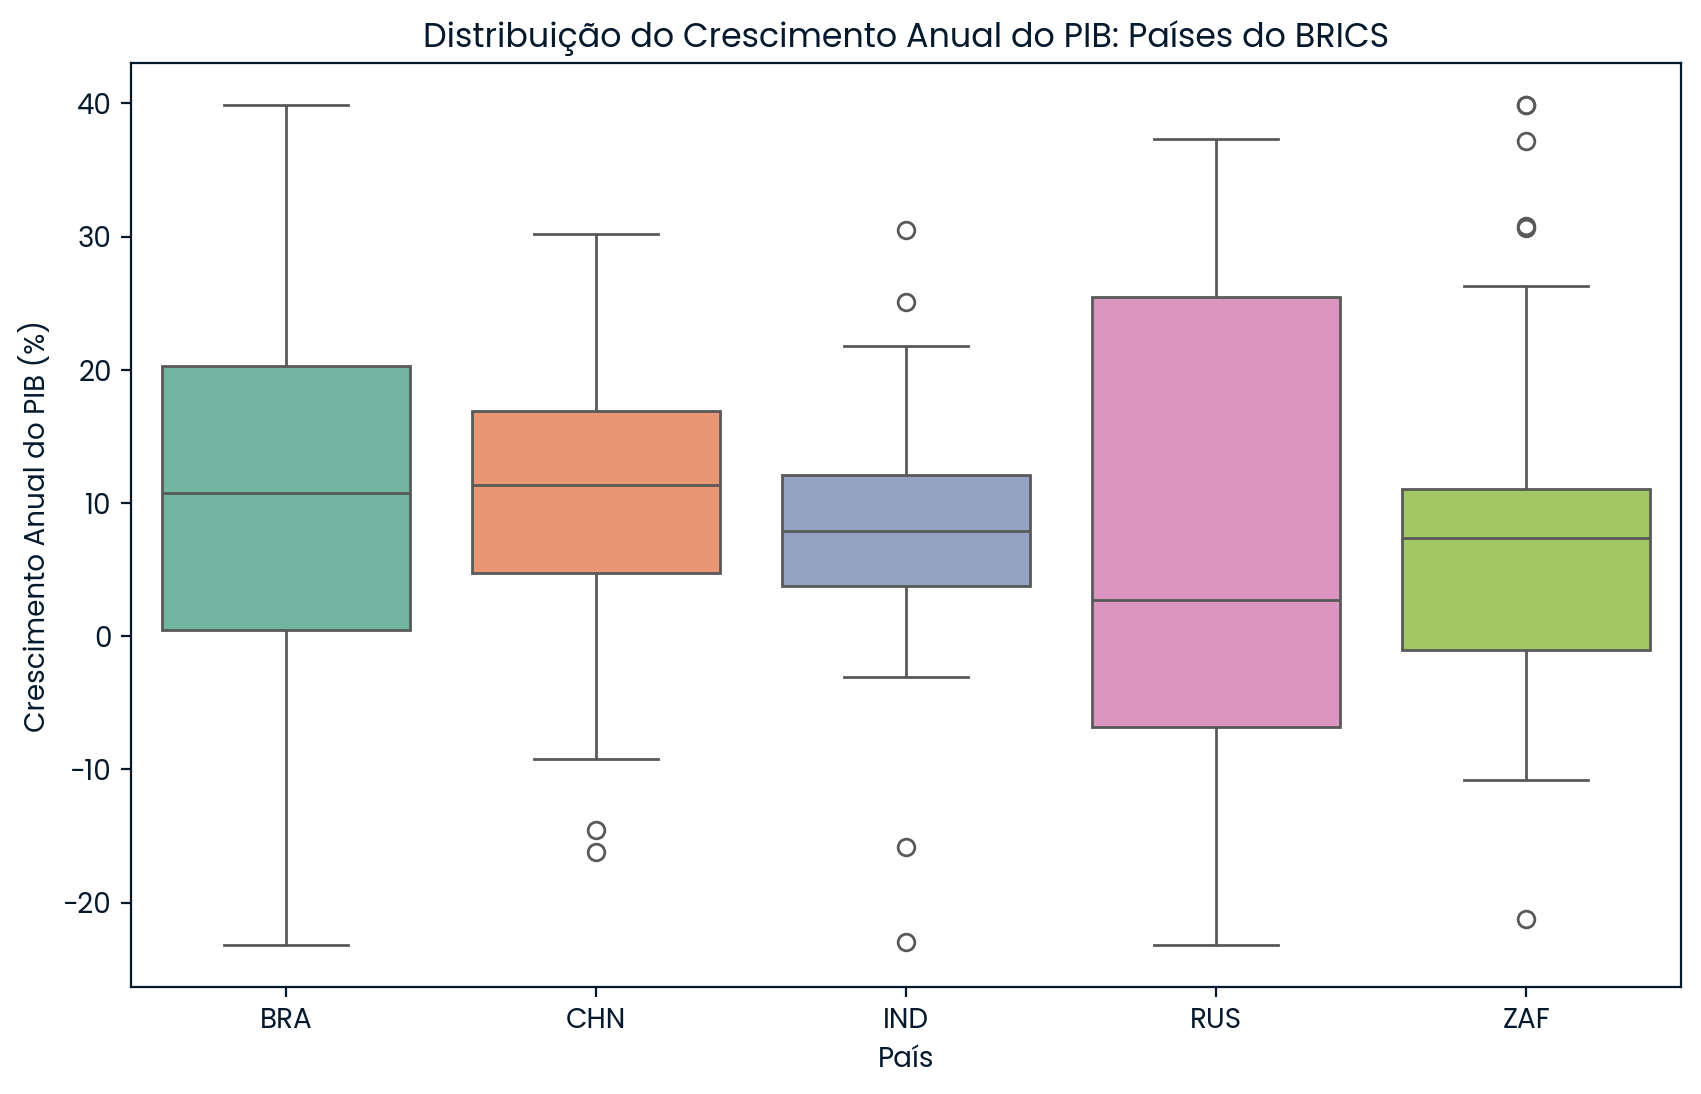

In [9]:
# Visualização
plt.figure(figsize=(10, 6))
sns.boxplot(data=brics_data, x='Country Code', y='Growth', palette='Set2')
plt.title('Distribuição do Crescimento Anual do PIB: Países do BRICS')
plt.xlabel('País')
plt.ylabel('Crescimento Anual do PIB (%)')
plt.show()

## Indicadores de Qualidade de Vida


### Análise 3: IDH na América do Sul
Os países sul-americanos em relação ao IDH.

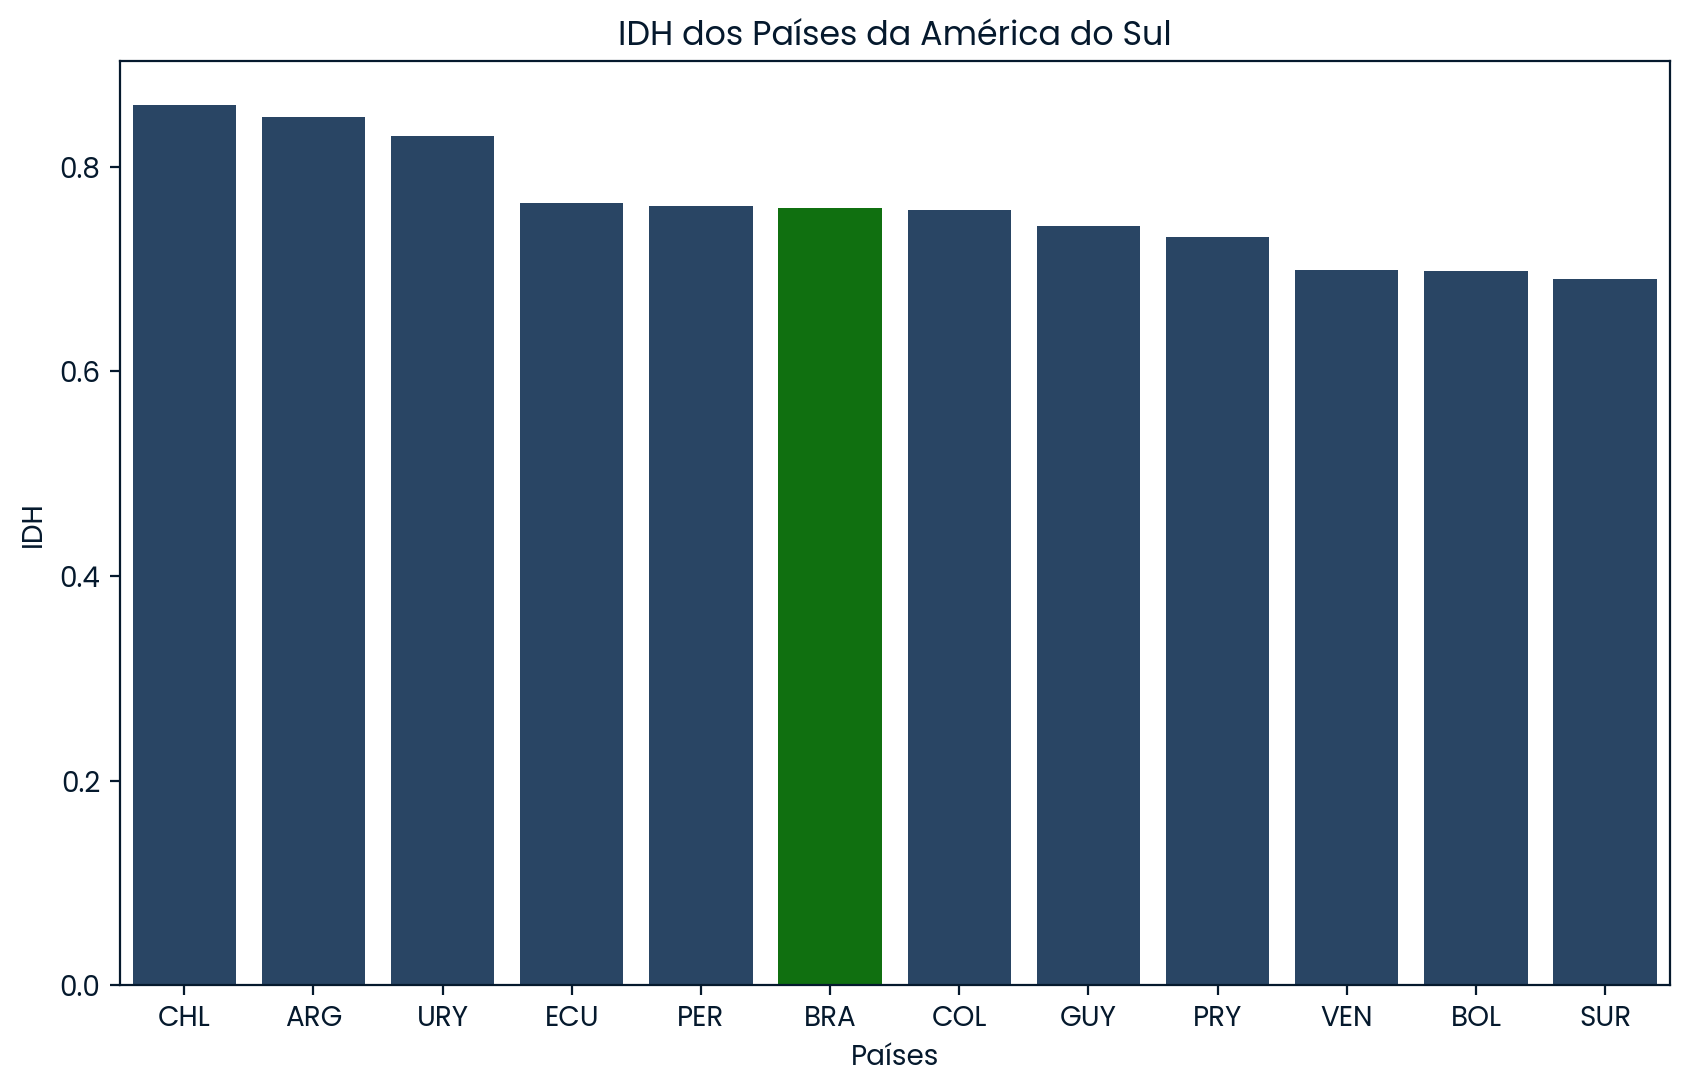

In [13]:
# Filtrar países da América do Sul
south_american_countries = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
south_american_data = world_data[world_data['iso3'].isin(south_american_countries)].sort_values('hdi_2022', ascending=False)

# Cores para o gráfico
south_american_data['color'] = south_american_data['iso3'].apply(lambda x: 'green' if x == 'BRA' else '#1F456E')

# Visualização do IDH da América do Sul
plt.figure(figsize=(10, 6))
sns.barplot(data=south_american_data, x='iso3', y='hdi_2022', palette=south_american_data['color'].to_list())
plt.xlabel('Países')
plt.ylabel('IDH')
plt.title('IDH dos Países da América do Sul')
plt.show()

## Onde o Brasil se encontra em relação à expectativa de vida e IDH?

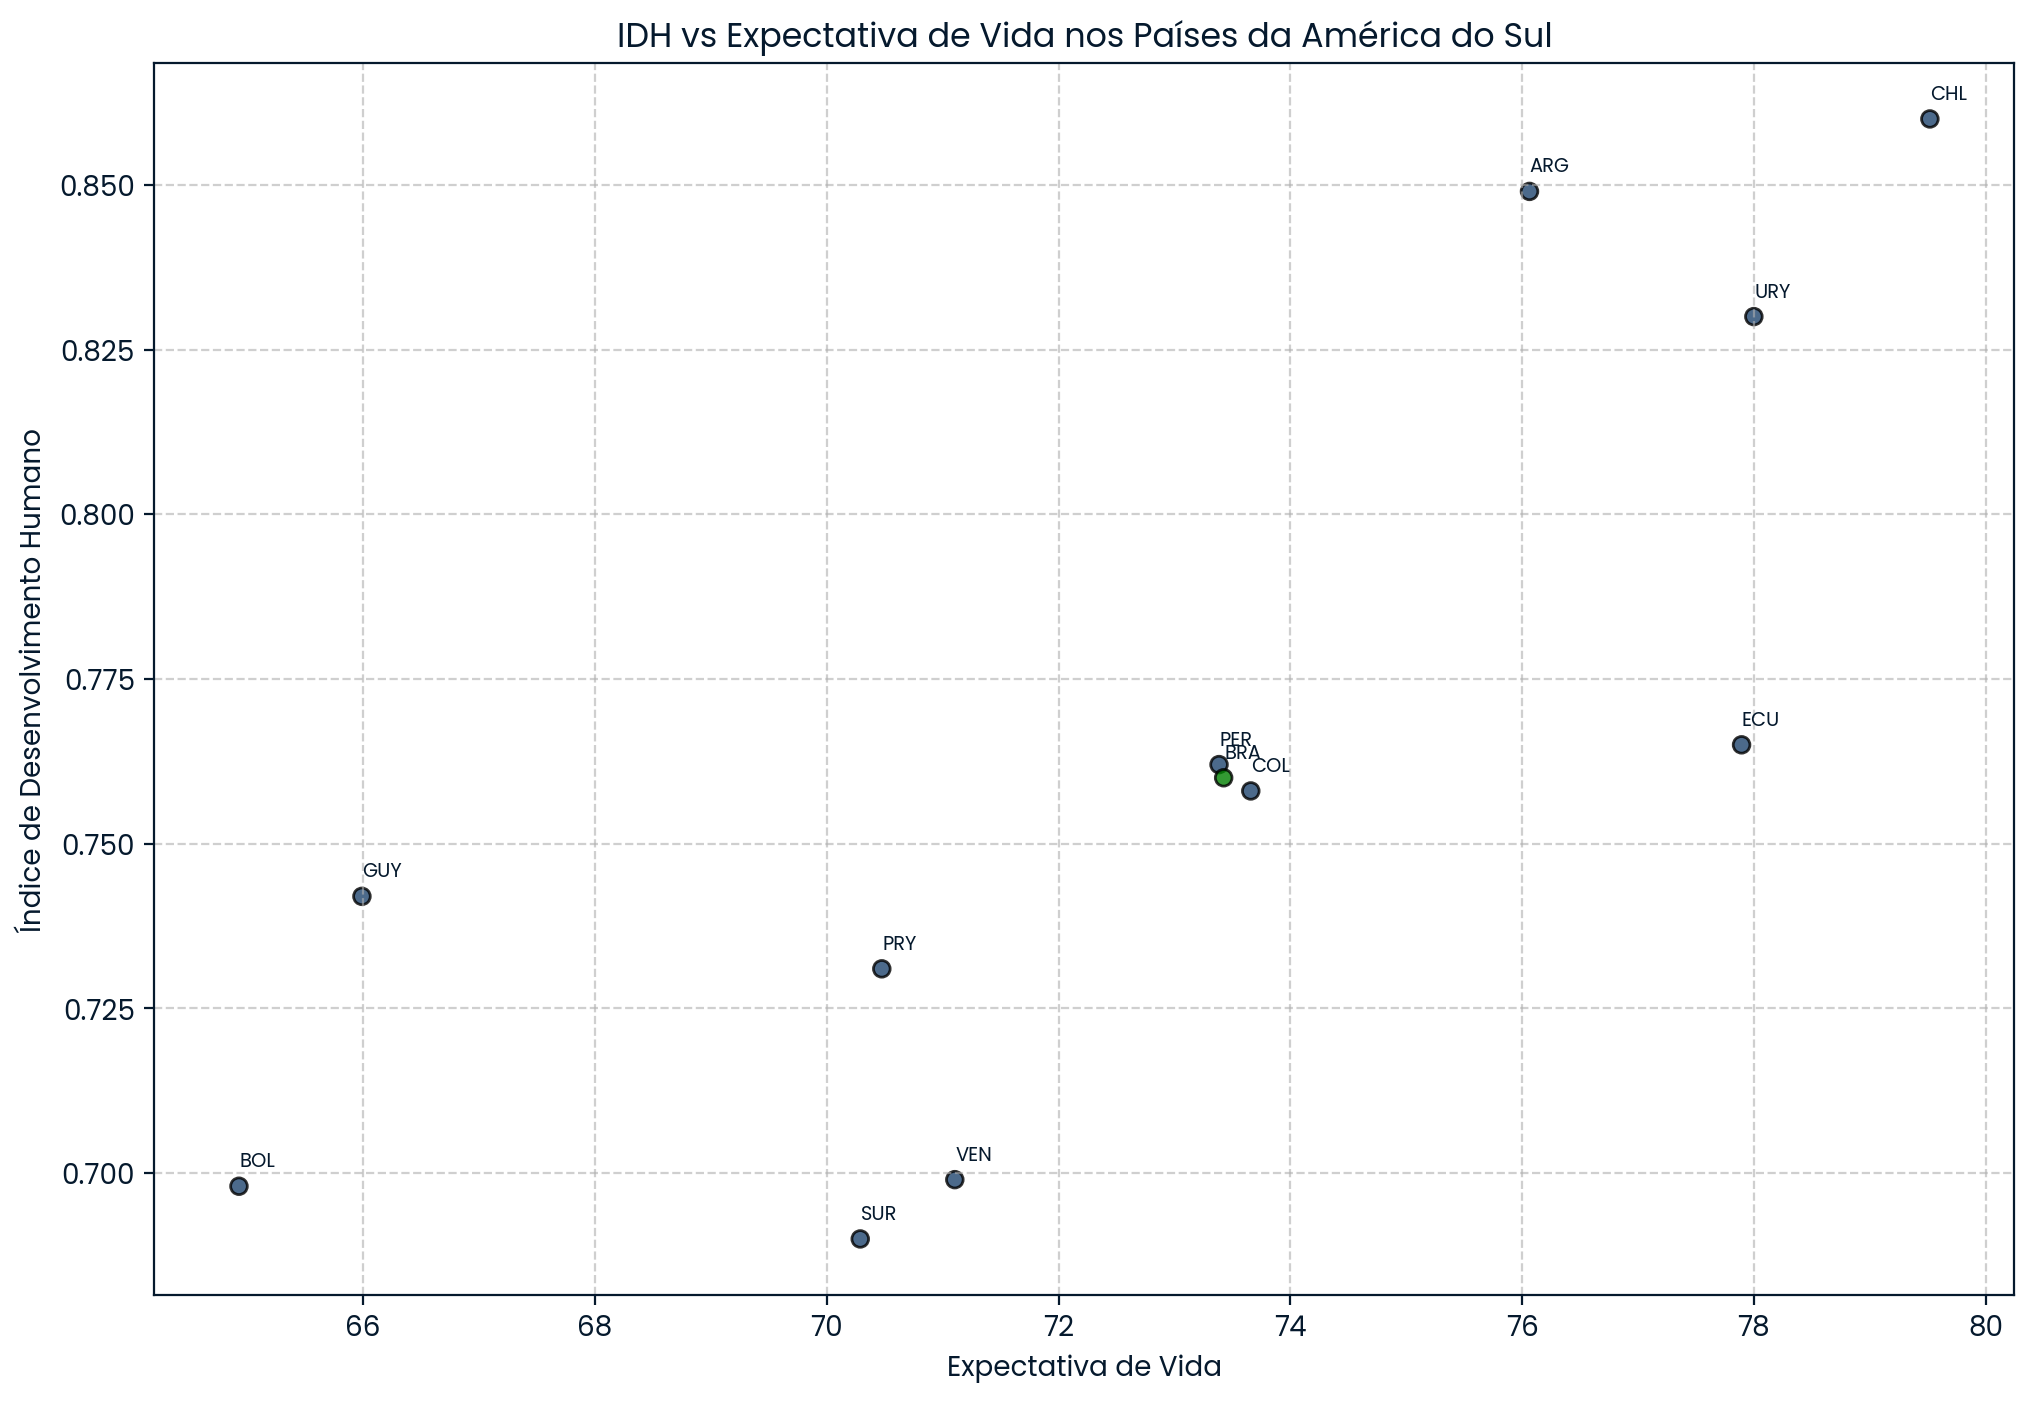

In [14]:
# Correlação entre expectativa de vida e IDH
plt.figure(figsize=(12, 8))
plt.scatter(south_american_data['le_2022'], south_american_data['hdi_2022'], color=south_american_data['color'], alpha=0.8, edgecolor='k')
for i, row in south_american_data.iterrows():
    plt.text(x=row['le_2022'] + 0.003, y=row['hdi_2022'] + 0.003, s=row['iso3'], fontsize=7)
plt.xlabel('Expectativa de Vida')
plt.ylabel('Índice de Desenvolvimento Humano')
plt.title('IDH vs Expectativa de Vida nos Países da América do Sul')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Conclusão
- O Brasil apresenta crescimento econômico alinhado, mas com desafios comparativos em relação a outros países em desenvolvimento.
- Países com maior expectativa de vida geralmente apresentam IDH mais elevado, destacando a relação entre qualidade de vida e desenvolvimento humano.
- Apesar do destaque do Brasil dentre os BRICS e países em desenvolvimento, ele ainda passsa por dificuldades em refletir seu crescimento dentro da população, sendo evidenciado pelo desempenho medíocre quando comparado à América do Sul.

Esses resultados evidenciam a importância de políticas focadas tanto no crescimento econômico quanto na melhoria dos indicadores sociais.